In [1]:
from numpy import matrix, linspace, array, interp
from control import ss, lqr, tf, step_response
from scipy.integrate import ode

In [2]:
%matplotlib inline
from matplotlib.pyplot import figure, style

style.use("fivethirtyeight")

In [3]:
a, b = matrix([[14.27545351],[27.54070936]])

In [4]:
A = matrix([[0, 1], [0, -a]])
B = matrix([[0], [b]])
C = matrix([[1, 0]])
D = matrix([[0]])

In [5]:
servo_HS = ss(A, B, C, D)

In [6]:
servo_HS.pole()

array([  0.        , -14.27545351])

In [7]:
Q, R = matrix([[100, 0], [0, 10]]), matrix([[1]])
K, S, E = lqr(servo_HS, Q, R)

In [8]:
K

array([[10.        ,  2.79751187]])

In [9]:
E

array([ -3.1225886+0.j, -88.198326 +0.j], dtype=complex64)

In [10]:
def escalon(t, mag):
    '''
    Esta función toma un vector con el estado del sistema, el tiempo de simulación
    y la magnitud del escalon a simular, y da como resultado el valor de la función
    escalón en el tiempo requerido.
    '''
    if t <= 0:
        y = 0
    else:
        y = mag
    return y

def motor_cd_simple(t, x, alg_control, a, b):
    '''
    Esta función toma un vector con el estado del sistema, el tiempo de simulación, 
    y nombre de función de entrada, y da como resultado la derivada del sistema,
    calculada a partir de la dinámica simplificada de un motor de corriente directa y de
    la señal de entrada del motor.
    '''
    y, ẏ = x
    u = alg_control(t, x)
    ÿ = b*u - a*ẏ
    return [ẏ, ÿ]

def control_pd(t, x, entrada, kp, kd):
    p_sat = 255
    e = entrada(t) - x[0]
    ep = - x[1]
    u = kp*e - kd*ep
    return int(max(min(p_sat, u), -p_sat))

In [11]:
s1 = lambda t: escalon(t, 127)
control_HS422 = lambda t, x: control_pd(t, x, s1, K[0][0], K[0][1]*0.01)
motor_HS422 = lambda t, x: motor_cd_simple(t, x, control_HS422, a, b)

In [12]:
sis = ode(motor_HS422)
sis.set_initial_value([0, 0])
sis.set_integrator('vode', nsteps=500, method="bdf");

In [13]:
t_sim = linspace(0, 10, 1000)
y_sim = [sis.integrate(t) for t in t_sim[1:]]
y_sim.insert(0, [0, 0])

In [16]:
def alg_control(xs, ts, kp, kd):
    p_sat = 255
    e = referencias(ts[-1]) - xs[-1]
    ep = (xs[-1] - xs[-2])
    u = kp*e - kd*ep
    return int(max(min(p_sat,u),-p_sat))

def referencias(t):
    from numpy import interp
    if t >= 5:
        return 127
    else:
        return 0

In [17]:
from serial import Serial
from time import time, sleep

In [18]:
xs = [0]
us = [0]
ts = [0]

with Serial("/dev/cu.usbmodem0E204D821", baudrate=57600) as puerto_arduino:
    while ts[-1] < 15:
        try:
            lec = int.from_bytes(puerto_arduino.read(6), byteorder='little')
            xs.append(int(lec/(2**32))/16)
            ts.append(int(lec%(2**32))*0.000001)
        except KeyboardInterrupt:
            break
        
        if len(xs) > 1:
            us.append(alg_control(xs[-2:], ts[-2:], K[0][0], K[0][1]))
        else:
            us.append(0)
            
        if us[-1] > 0:
            puerto_arduino.write(bytes([0, us[-1]]))
        else:
            puerto_arduino.write(bytes([1, abs(us[-1])]))
            
    puerto_arduino.write(bytes([0, 0]))

In [19]:
t_exp = []
q_exp = []
u_exp = []
for i, t in enumerate(ts):
    if t > 5:
        t_exp.append(ts[i])
        q_exp.append(xs[i])
        u_exp.append(us[i])

In [20]:
t_interp = linspace(5, 15, 1000)
q_interp = array([interp(t, t_exp, q_exp) for t in t_interp])
u_interp = array([interp(t, t_exp, u_exp) for t in t_interp])

In [21]:
t_desf = t_interp - 5

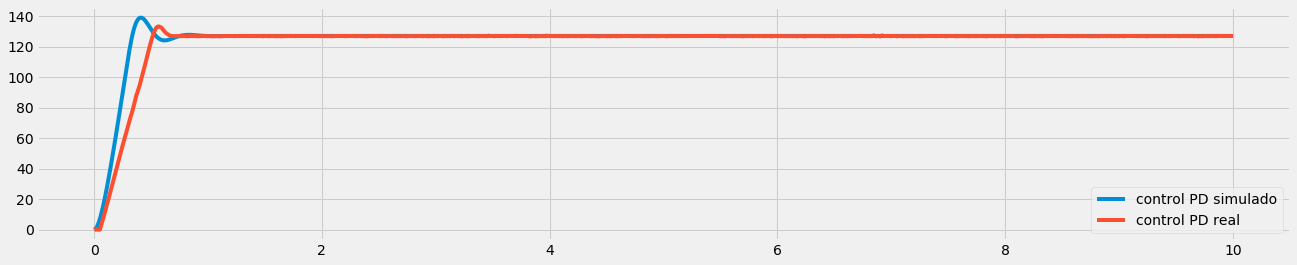

In [22]:
fig = figure(figsize=(20, 4))
ax = fig.gca()
p1, = ax.plot(t_sim, array(y_sim).T[0])
p2, = ax.plot(t_desf, q_interp);
ax.legend([p1, p2], ["control PD simulado", "control PD real"]);